<a href="https://colab.research.google.com/github/yangxy/GPEN/blob/main/GPEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before start, make sure that you choose

*   Python>=3.6
*   PyTorch>=1.7.1
*   CUDA>=10.0
*   CUDA Driver>=440
*   GCC>=4.9

in the Runtime menu --> Change runtime type

First, we clone the repository.

In [ ]:
# clone the repository
%cd /content
!rm -rf GPEN
!git clone https://github.com/yangxy/GPEN.git
%cd GPEN

/content
Cloning into 'GPEN'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 606 (delta 0), reused 5 (delta 0), pack-reused 591
Receiving objects: 100% (606/606), 125.07 MiB | 43.22 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/GPEN


Then, we set up the environment. 

In [ ]:
# set up the environment 
!pip install -r requirements.txt

     |████████████████████████████████| 108 kB 4.6 MB/s 


Download the pre-trained models and put them in ./weights.

In [ ]:
# download our pre-trained models
!wget "https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/RetinaFace-R50.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116085&Signature=GlUNW6%2B8FxvxWmE9jKIZYOOciKQ%3D" -O weights/RetinaFace-R50.pth
!wget "https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/GPEN-BFR-512.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116208&Signature=hBgvVvKVSNGeXqT8glG%2Bd2t2OKc%3D" -O weights/GPEN-BFR-512.pth
!wget "https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/GPEN-BFR-256.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116259&Signature=kMGJLSHqnvzzzqwtjUVBgngzX2s%3D" -O weights/GPEN-BFR-256.pth
!wget "https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/realesrnet_x2.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1962694780&Signature=lI%2FolhA%2FyigiTRvoDIVbtMIyhjI%3D" -O weights/realesrnet_x2.pth
!wget "https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/ParseNet-latest.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116134&Signature=bnMwU1JogmNbARto6G%2B7iaJQCHs%3D" -O weights/ParseNet-latest.pth

--2022-05-17 02:55:52--  https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/RetinaFace-R50.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116085&Signature=GlUNW6%2B8FxvxWmE9jKIZYOOciKQ%3D
Resolving public-vigen-video.oss-cn-shanghai.aliyuncs.com (public-vigen-video.oss-cn-shanghai.aliyuncs.com)... 47.101.88.25
Connecting to public-vigen-video.oss-cn-shanghai.aliyuncs.com (public-vigen-video.oss-cn-shanghai.aliyuncs.com)|47.101.88.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109497761 (104M) [application/octet-stream]
Saving to: ‘weights/RetinaFace-R50.pth’

weights/RetinaFace- 100%[===================>] 104.42M  10.9MB/s    in 19s     

2022-05-17 02:56:12 (5.60 MB/s) - ‘weights/RetinaFace-R50.pth’ saved [109497761/109497761]

--2022-05-17 02:56:12--  https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/GPEN-BFR-512.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116208&Signature=hBgvVvKVSNGeXqT8glG%2Bd2

Finally, run our model.

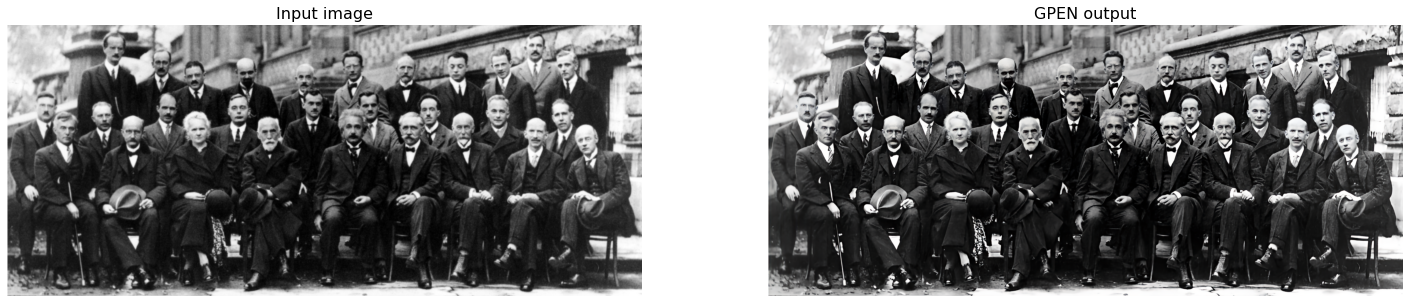

In [ ]:
# enhance faces
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

import __init_paths
from face_enhancement import FaceEnhancement

def display(img1, img2):
    fig = plt.figure(figsize=(25, 10))
    ax1 = fig.add_subplot(1, 2, 1) 
    plt.title('Input image', fontsize=16)
    ax1.axis('off')
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('GPEN output', fontsize=16)
    ax2.axis('off')
    ax1.imshow(img1)
    ax2.imshow(img2)

if __name__=="__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--model', type=str, default='GPEN-BFR-512', help='GPEN model')
    parser.add_argument('--task', type=str, default='FaceEnhancement', help='task of GPEN model')
    parser.add_argument('--key', type=str, default=None, help='key of GPEN model')
    parser.add_argument('--in_size', type=int, default=512, help='in resolution of GPEN')
    parser.add_argument('--out_size', type=int, default=None, help='out resolution of GPEN')
    parser.add_argument('--channel_multiplier', type=int, default=2, help='channel multiplier of GPEN')
    parser.add_argument('--narrow', type=float, default=1, help='channel narrow scale')
    parser.add_argument('--alpha', type=float, default=1, help='blending the results')
    parser.add_argument('--use_sr', action='store_true', help='use sr or not')
    parser.add_argument('--use_cuda', action='store_true', help='use cuda or not')
    parser.add_argument('--save_face', action='store_true', help='save face or not')
    parser.add_argument('--aligned', action='store_true', help='input are aligned faces or not')
    parser.add_argument('--sr_model', type=str, default='realesrnet', help='SR model')
    parser.add_argument('--sr_scale', type=int, default=2, help='SR scale')
    parser.add_argument('--tile_size', type=int, default=0, help='tile size for SR to avoid OOM')
    parser.add_argument('--indir', type=str, default='examples/imgs', help='input folder')
    parser.add_argument('--outdir', type=str, default='results/outs-bfr', help='output folder')
    parser.add_argument('--ext', type=str, default='.jpg', help='extension of output')
    args = parser.parse_args() 

    #model = {'name':'GPEN-BFR-512', 'sr_model':'realesrnet', 'sr_scale': 2, 'size':512, 'channel_multiplier':2, 'narrow':1}
    #model = {'name':'GPEN-BFR-256', 'sr_model':'realesrnet', 'size':256, 'channel_multiplier':1, 'narrow':0.5}
    
    os.makedirs(args.outdir, exist_ok=True)

    faceenhancer = FaceEnhancement(args, in_size=args.in_size, model=args.model, use_sr=args.use_sr, device='cuda' if args.use_cuda else 'cpu')

    file = os.path.join(indir, 'Solvay_conference_1927.png')
    filename, ext = os.path.splitext(os.path.basename(file))
    img = cv2.imread(file, cv2.IMREAD_COLOR) # BGR
    #im = cv2.resize(im, (0,0), fx=2, fy=2) #optional

    img_out, orig_faces, enhanced_faces = faceenhancer.process(img, aligned=False)
    
    img = cv2.resize(img, img_out.shape[:2][::-1])
    cv2.imwrite(f'{outdir}/{filename}_COMP.jpg', np.hstack((img, img_out)))
    cv2.imwrite(f'{outdir}/{filename}_GPEN.jpg', img_out)
        
    for m, (ef, of) in enumerate(zip(enhanced_faces, orig_faces)):
        of = cv2.resize(of, ef.shape[:2])
        cv2.imwrite(f'{outdir}/{filename}_face{m:02d}.jpg', np.hstack((of, ef)))
    
    display(img, img_out)

Download the results if needed.

In [ ]:
# download the result
from google.colab import files

!ls examples/outs-bfr/
os.system('zip -r BFR-results.zip examples/outs-bfr')
files.download("BFR-results.zip")

Solvay_conference_1927_COMP.jpg    Solvay_conference_1927_face15.jpg
Solvay_conference_1927_face00.jpg  Solvay_conference_1927_face16.jpg
Solvay_conference_1927_face01.jpg  Solvay_conference_1927_face17.jpg
Solvay_conference_1927_face02.jpg  Solvay_conference_1927_face18.jpg
Solvay_conference_1927_face03.jpg  Solvay_conference_1927_face19.jpg
Solvay_conference_1927_face04.jpg  Solvay_conference_1927_face20.jpg
Solvay_conference_1927_face05.jpg  Solvay_conference_1927_face21.jpg
Solvay_conference_1927_face06.jpg  Solvay_conference_1927_face22.jpg
Solvay_conference_1927_face07.jpg  Solvay_conference_1927_face23.jpg
Solvay_conference_1927_face08.jpg  Solvay_conference_1927_face24.jpg
Solvay_conference_1927_face09.jpg  Solvay_conference_1927_face25.jpg
Solvay_conference_1927_face10.jpg  Solvay_conference_1927_face26.jpg
Solvay_conference_1927_face11.jpg  Solvay_conference_1927_face27.jpg
Solvay_conference_1927_face12.jpg  Solvay_conference_1927_face28.jpg
Solvay_conference_1927_face13.jpg 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>